In [1]:
import numpy as np
import pandas as pd
import roman as roman
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
# from catboost import CatBoostClassifier
# from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV
import math
import roman

In [45]:
warnings.filterwarnings("ignore")

In [356]:
data = pd.read_csv("train-2.csv")

In [357]:
answer = list(set(data[data.TargetClass == 0].SpType.unique()) & set(data[data.TargetClass == 1].SpType.unique()))

In [358]:
answer

['G8IV...',
 'G4V:p',
 'B7Ib',
 'F3V:+...',
 'G8III/IV',
 'K0IV:',
 'B2V+...',
 'K7V',
 'F9III',
 'G7IV',
 'K0:III+...',
 'G3V',
 'G3IV/V',
 'K0VCN...',
 'F0III:',
 'B2IV-Ve',
 'B1.5III-IVn',
 'B3Vn...',
 'A2II/III',
 'K1/2III: +F',
 'B0.5IVn',
 'F0IIw...',
 'G6IV',
 'B7/B8II/III',
 'B6II/III',
 'F8III/IV',
 'A2V+...',
 'A4V comp SB',
 'G9III-IV',
 'K3V',
 'O9.5Ia SB:',
 'K3III+A0IV/V',
 'F3IVp...',
 'K1III-IV',
 'G8IV',
 'G9IV',
 'B8Ia-Iab',
 'B8II',
 'K1IV/V',
 'B3III',
 'K0/K1IVwp..',
 'A3II/IIIm..',
 'A8III',
 'G5III-IV',
 'K1IVCN...',
 'B2.5V',
 'B9V+...',
 'F0/F2IVm...',
 'B6III',
 'F4IIIvar',
 'K0IV/VCNIII',
 'G8/K0IV/V',
 'B5Ia',
 'B0Ib/II',
 'B7Iab...',
 'K3III',
 'G6IV/V',
 'G6V',
 'A6III',
 'A3II/III',
 'A(V) + G5III',
 'A4/A5III:',
 'A2/A3III',
 'A3III + K1:',
 'B2III-IV',
 'K1IV...',
 'G6/G8III/IV',
 'K0IVw...',
 'G9V',
 'B4II',
 'G5V',
 'B6/B7II',
 'K1/K2V',
 'A6:III:+...',
 'K1IV',
 'F6/F7V',
 'K3IV/V',
 'A3Vs',
 'B7Ib/II',
 'K2/K3V',
 'B0IVpe',
 'G8IVp',
 'G3/G5Vw',
 'B

In [359]:
data = data[~data.SpType.isin(answer)]

In [360]:
color_index = lambda x: 4600 * ((1 / (0.92 * x + 1.7)) + (1 / (0.92 * x + 0.62)))
round_ = lambda x: round(x, 1)
def transform_type2(x):
    x1 = x
    x1 = x1.replace('I', '')
    x1 = x1.replace('V', '')
    lst = list(set(x1))
    for i in lst:
        x = x.replace(i, ' ')
    x = x.split()[-1]
    return roman.fromRoman(x) * 1000
transform_type = lambda x: 1 if "V" in x or "VI" in x or "VII" in x else -1
# avag =

In [361]:
Ms = 3.86 * 10 ** 33
data["temp"] = data["B-V"].apply(color_index)
data["R"] = np.sqrt(data.Vmag) / np.power(data.temp / 5778, 2)
data["M"] = data.Vmag + 5 - (5 * np.log(data.Plx))
data["L"] = np.power(data.R, 2) * np.power(data.temp / 5778, 4)

In [422]:
data.M.min()

-14.678000816908899

In [362]:
data.head()

,Vmag,Plx,e_Plx,B-V,SpType,Amag,TargetClass,temp,R,M,L
1,4.334196,2.198947,0.593309,1.153210,G2Ib,13.043324,0,4402.632871,3.585786,5.394303,4.334196
2,7.873019,11.750465,0.616568,0.589166,F5V,17.736492,1,6010.288989,2.593194,0.553555,7.873019
3,8.110014,2.143815,0.848508,1.322107,K2III,15.592469,0,4082.305608,5.704989,9.297079,8.110014
4,8.025193,4.165622,0.899296,1.141646,K5III,16.379680,0,4426.508743,4.826810,5.890864,8.025193
5,2.899130,11.110086,0.701719,1.095357,M0III,14.370388,0,4524.866088,2.776371,-4.140137,2.899130


In [363]:
# data["spt2"] = data.SpType.apply(transform_type2)
data.SpType = data.SpType.apply(transform_type)

In [364]:
data.head()

,Vmag,Plx,e_Plx,B-V,SpType,Amag,TargetClass,temp,R,M,L
1,4.334196,2.198947,0.593309,1.153210,-1,13.043324,0,4402.632871,3.585786,5.394303,4.334196
2,7.873019,11.750465,0.616568,0.589166,1,17.736492,1,6010.288989,2.593194,0.553555,7.873019
3,8.110014,2.143815,0.848508,1.322107,-1,15.592469,0,4082.305608,5.704989,9.297079,8.110014
4,8.025193,4.165622,0.899296,1.141646,-1,16.379680,0,4426.508743,4.826810,5.890864,8.025193
5,2.899130,11.110086,0.701719,1.095357,-1,14.370388,0,4524.866088,2.776371,-4.140137,2.899130


In [365]:
data = data[data.Plx + data.e_Plx > 0]

In [366]:
# plt.boxplot(data.Vmag)

In [367]:
# data = data[(data.Vmag > 4) & (data.Vmag < 11)]

In [368]:
# plt.boxplot(data["B-V"])

In [369]:
# data = data[data["B-V"] < 23]

In [370]:
# plt.boxplot(data.Amag)

In [371]:
# data = data[(data.Amag < 22) & (data.Amag > 10)]

In [372]:
# data.Amag = data.Amag.apply(round_)
# data.Vmag = data.Vmag.apply(round_)
# data.Plx = data.Plx.apply(round_)
# data.e_Plx = data.e_Plx.apply(round_)
# data["B-V"] = data["B-V"].apply(round_)
# data.temp = data.temp.apply(round_)
# model["BVtype"] = round(model["B-V"] * model.SpType)

In [373]:
# data = data.drop( ["e_Plx"], axis=1)

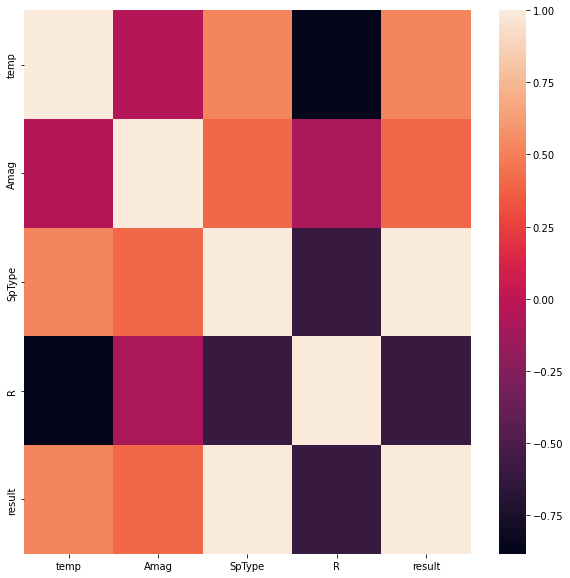

In [398]:
y = data['TargetClass']
# X = data.drop(columns=['TargetClass'])
X = data[["temp", "Amag", "SpType", "R"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=5, test_size=0.2)

fig = plt.figure(figsize=(10, 10))
X_test2 = X_test.copy()
X_test2["result"] = y_test
data_ploting = X_test2.corr(method='pearson')
sns.heatmap(data_ploting, linecolor='black')
plt.show()

In [399]:
data.head()

,Vmag,Plx,e_Plx,B-V,SpType,Amag,TargetClass,temp,R,M,L
1,4.334196,2.198947,0.593309,1.153210,-1,13.043324,0,4402.632871,3.585786,5.394303,4.334196
2,7.873019,11.750465,0.616568,0.589166,1,17.736492,1,6010.288989,2.593194,0.553555,7.873019
3,8.110014,2.143815,0.848508,1.322107,-1,15.592469,0,4082.305608,5.704989,9.297079,8.110014
4,8.025193,4.165622,0.899296,1.141646,-1,16.379680,0,4426.508743,4.826810,5.890864,8.025193
5,2.899130,11.110086,0.701719,1.095357,-1,14.370388,0,4524.866088,2.776371,-4.140137,2.899130


In [400]:
%%time
xgb = XGBClassifier(subsample=0.8,
                    min_child_weight=1,
                    max_depth=14,
                    gamma=1,
                    colsample_bytree=0.8)
xgb.fit(X, y)

CPU times: user 3.87 s, sys: 1.82 s, total: 5.69 s
Wall time: 1.07 s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=1, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=14, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [401]:
pred = xgb.predict(X_test)

In [402]:
roc_auc_score(y_test, pred)

0.999801429706116

In [403]:
def check(M):
    if M > 0:
        return 1
    else:
        return 0


In [404]:
data_ = pd.read_csv("predict.csv")

In [405]:
data_test = data_.copy()

In [406]:
Ms = 3.86 * 10 ** 33
data_test["temp"] = data_test["B-V"].apply(color_index)
data_test["R"] = np.sqrt(data_test.Vmag) / np.power(data_test.temp / 5778, 2)
data_test["M"] = data_test.Vmag + 5 - (5 * np.log(data_test.Plx))
data_test["L"] = np.power(data_test.R, 2) * np.power(data_test.temp / 5778, 4)

In [407]:
list(data.columns) == list(data_test.columns)

False

In [408]:
data.columns

Index(['Vmag', 'Plx', 'e_Plx', 'B-V', 'SpType', 'Amag', 'TargetClass', 'temp',
       'R', 'M', 'L'],
      dtype='object')

In [409]:
data_test.columns

Index(['Vmag', 'Plx', 'e_Plx', 'B-V', 'SpType', 'Amag', 'temp', 'R', 'M', 'L'], dtype='object')

In [410]:
data_test.head()

,Vmag,Plx,e_Plx,B-V,SpType,Amag,temp,R,M,L
0,4.039519,13.596504,0.845101,-0.097823,F5V+...,15.774122,11536.343340,0.504178,-4.009545,4.039519
1,6.655719,4.010332,1.050017,1.386670,K5III,15.344976,3972.332732,5.458349,4.711348,6.655719
2,6.405060,0.348855,0.961598,0.951503,B0IVpe,12.236103,4862.277063,3.573858,16.670551,6.405060
3,9.113068,2.954461,1.251422,1.002819,K1III,15.560838,4735.981168,4.493321,8.696487,9.113068
4,6.107686,3.144180,0.475795,0.493345,G8II-IIIvar,12.771981,6419.225528,2.002295,5.379920,6.107686


In [411]:
data_test.SpType = data_test.SpType.apply(transform_type)

In [414]:
pred = xgb.predict(data_test[["temp", "Amag", "SpType", "R"]].values)

In [415]:
# pred =[check(i) for i in data_test.M]

In [416]:
data_["TargetClass"] = pred

In [417]:
data_

,Vmag,Plx,e_Plx,B-V,SpType,Amag,TargetClass
0,4.039519,13.596504,0.845101,-0.097823,F5V+...,15.774122,1
1,6.655719,4.010332,1.050017,1.386670,K5III,15.344976,0
2,6.405060,0.348855,0.961598,0.951503,B0IVpe,12.236103,1
3,9.113068,2.954461,1.251422,1.002819,K1III,15.560838,0
4,6.107686,3.144180,0.475795,0.493345,G8II-IIIvar,12.771981,0
...,...,...,...,...,...,...,...
7906,8.255272,2.858885,0.822289,1.349195,M3III,16.438014,0
7907,6.255358,3.034436,0.449386,0.966053,K0III,13.898403,0
7908,8.643598,10.932145,0.947897,0.504383,G0V,18.980729,1
7909,9.400810,6.279361,1.332124,0.351073,F2V,16.872491,1


In [418]:
data_.to_csv("answer.csv")